### **코드 구동 전에 꼭 주석해제하고 설치해주세요! 설치 후에는 주석 처리 권장**

In [2]:
# # !pip show scipy
# # !pip install nltk
# # !pip install pandas
# # !pip install contractions
# import nltk # 수정 감사합니다~
# nltk.download('punkt') # 오래 걸림..
# nltk.download('omw-1.4')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# # !pip install pyLDAvis
# !pip install gensim
# !pip install scikit-learn

### 사용 라이브러리들

In [4]:
import re
import os
import nltk
import string
import gensim
import pyLDAvis
import numpy as np
import contractions
import pandas as pd
from tqdm import tqdm
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim as gensimvis
from matplotlib import pyplot as plt
from gensim import corpora, models
from gensim.models import doc2vec
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.doc2vec import TaggedDocument
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None) # Pandas 전체 열 확인
pd.set_option('display.max_rows', None) # Pandas 전체 행 확인

### 1. 데이터 로딩

In [6]:
df = pd.read_csv("./1. Data/LG_Flipkart_Amazon_Total.csv") # 로드할 데이터의 (상대 or 절대) 경로를 지정
df_original = df
df.head()

,Unnamed: 0,text,star
0,0,Waste of money . AC not working till one month...,1
1,1,I purchased this LG A. C. on 17 April 23..The ...,1
2,2,If you want to buy a white showpiece for your ...,1
3,3,Totally waste of money. company is not refund ...,1
4,4,"This model don't have 4 way swing, it's actual...",1


In [7]:
# 차후 분석할 원본 텍스트 데이터의 컬럼명 저장
df_original_column = "text"

#### 옵션) 별점, 지역 등을 기준으로 필터링하실 분들은 아래에 코드 추가해서 진행 바랍니다

In [9]:
# df = df[df["star"] == 5] # 예시. 별점으로 분류할 경우
# df.head()

### 2. 데이터 전처리
1. 결측 데이터 여부 확인
1-2. 결측 데이터 확인시 다른 데이터(공백이나 0 등)로 대체
2. 이모지 제거 -> 텍스트 전처리 시작
3. 소문자 변환 
4. 수축형 확장
5. 구두점 제거
6. 불용어 제거
7. 표제어 추출
8. 단일 글자 제거
9. 숫자 제거

---
- 특정 데이터만 전처리를 원할 경우 코드 수정해서 사용해주세요! (예. df['특정열'])

In [11]:
# 로딩한 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8168 entries, 0 to 8167
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8168 non-null   int64 
 1   text        8111 non-null   object
 2   star        8168 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 191.6+ KB


#### 1) 결측 데이터 여부 확인

In [13]:
df.isnull().sum()

Unnamed: 0     0
text          57
star           0
dtype: int64

#### 1-2) 결측 데이터 대체
- 임시 방안

In [15]:
df = df.fillna('') # 결측치가 있는 경우
df.isnull().sum() # 결측치 데이터 여부 재확인

Unnamed: 0    0
text          0
star          0
dtype: int64

#### 2) 이모지 제거
- 영어 제외 언어들도 제거?
  - 아스키(American ~) 코드를 기준으로 제거했기 때문에 다른 언어들도 함께 제거되는 것으로 추정

In [17]:
# 텍스트에서 이모지를 제거하는 함수
# 아스키 코드로 변환 후 제거
def rmEmoji_ascii(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

# DataFrame의 모든 문자열에 적용
def df_remove_emoji(df):
    return df.map(lambda x: rmEmoji_ascii(x) if isinstance(x, str) else x)

In [18]:
# Before
df.head()

,Unnamed: 0,text,star
0,0,Waste of money . AC not working till one month...,1
1,1,I purchased this LG A. C. on 17 April 23..The ...,1
2,2,If you want to buy a white showpiece for your ...,1
3,3,Totally waste of money. company is not refund ...,1
4,4,"This model don't have 4 way swing, it's actual...",1


In [19]:
# After
df = df_remove_emoji(df)
df.head()

,Unnamed: 0,text,star
0,0,Waste of money . AC not working till one month...,1
1,1,I purchased this LG A. C. on 17 April 23..The ...,1
2,2,If you want to buy a white showpiece for your ...,1
3,3,Totally waste of money. company is not refund ...,1
4,4,"This model don't have 4 way swing, it's actual...",1


#### 3) 소문자 변환

In [21]:
# DataFrame의 모든 열에 대해 문자열을 소문자로 변환하는 함수
# 문자열이 아닌 경우는 그대로 유지
def df_lowercase(df):
    return df.map(lambda x: x.lower() if isinstance(x, str) else x)

In [22]:
# Before
df.head()

,Unnamed: 0,text,star
0,0,Waste of money . AC not working till one month...,1
1,1,I purchased this LG A. C. on 17 April 23..The ...,1
2,2,If you want to buy a white showpiece for your ...,1
3,3,Totally waste of money. company is not refund ...,1
4,4,"This model don't have 4 way swing, it's actual...",1


In [23]:
# After
df = df_lowercase(df)
df.head()

,Unnamed: 0,text,star
0,0,waste of money . ac not working till one month...,1
1,1,i purchased this lg a. c. on 17 april 23..the ...,1
2,2,if you want to buy a white showpiece for your ...,1
3,3,totally waste of money. company is not refund ...,1
4,4,"this model don't have 4 way swing, it's actual...",1


#### 4) 수축형 확장
- don't -> do not, aren't -> are not, etc 

In [25]:
# DataFrame의 모든 문자열 열에서 수축형을 확장하는 함수.
# 문자열이 아닌 경우는 그대로 유지
def df_expand_contractions(df):
     return df.map(lambda x: contractions.fix(x) if isinstance(x, str) else x)

In [26]:
# Before
df.head()

,Unnamed: 0,text,star
0,0,waste of money . ac not working till one month...,1
1,1,i purchased this lg a. c. on 17 april 23..the ...,1
2,2,if you want to buy a white showpiece for your ...,1
3,3,totally waste of money. company is not refund ...,1
4,4,"this model don't have 4 way swing, it's actual...",1


In [27]:
# After
df = df_expand_contractions(df)
df.head()

,Unnamed: 0,text,star
0,0,waste of money . ac not working till one month...,1
1,1,i purchased this lg a. c. on 17 april 23..the ...,1
2,2,if you want to buy a white showpiece for your ...,1
3,3,totally waste of money. company is not refund ...,1
4,4,"this model do not have 4 way swing, it is actu...",1


#### 5) 구두점 제거
- ?,!. 과 같이 텍스트 분석에 불필요한 요소들 제거
- 필요시, 해당 부분은 일부 데이터를 제외하고 적용되도록 수정해서 사용 요망..(날짜, 모델명 등)

In [29]:
def df_remove_punctuation(df):
    return df.map(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)

In [30]:
df.head()

,Unnamed: 0,text,star
0,0,waste of money . ac not working till one month...,1
1,1,i purchased this lg a. c. on 17 april 23..the ...,1
2,2,if you want to buy a white showpiece for your ...,1
3,3,totally waste of money. company is not refund ...,1
4,4,"this model do not have 4 way swing, it is actu...",1


In [31]:
df = df_remove_punctuation(df)
df.head()

,Unnamed: 0,text,star
0,0,waste of money ac not working till one month ...,1
1,1,i purchased this lg a c on 17 april 23the most...,1
2,2,if you want to buy a white showpiece for your ...,1
3,3,totally waste of money company is not refund m...,1
4,4,this model do not have 4 way swing it is actua...,1


#### 6) 불용어 제거
- nltk 불용어 사전 적용

In [33]:
# Before
df.head()

,Unnamed: 0,text,star
0,0,waste of money ac not working till one month ...,1
1,1,i purchased this lg a c on 17 april 23the most...,1
2,2,if you want to buy a white showpiece for your ...,1
3,3,totally waste of money company is not refund m...,1
4,4,this model do not have 4 way swing it is actua...,1


In [34]:
# 불용어 목록 가져오기
stop_words = set(stopwords.words('english'))

In [35]:
# 불용어 제거 함수
def remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)  # 텍스트를 단어로 토큰화
        filtered_words = [word for word in words if word.lower() not in stop_words]  # 불용어 제거
        return ' '.join(filtered_words)  # 필터링된 단어들을 다시 하나의 문자열로 결합
    else:
        return text  # 문자열이 아닌 경우 그대로 반환

def df_remove_stopwords(df):
    return df.map(remove_stopwords)

In [36]:
# Before
df.head()

,Unnamed: 0,text,star
0,0,waste of money ac not working till one month ...,1
1,1,i purchased this lg a c on 17 april 23the most...,1
2,2,if you want to buy a white showpiece for your ...,1
3,3,totally waste of money company is not refund m...,1
4,4,this model do not have 4 way swing it is actua...,1


In [37]:
# After
df = df_remove_stopwords(df)
df.head()

,Unnamed: 0,text,star
0,0,waste money ac working till one month installa...,1
1,1,purchased lg c 17 april 23the horrible experie...,1
2,2,want buy white showpiece bedroom go ahead othe...,1
3,3,totally waste money company refund money per p...,1
4,4,model 4 way swing actual ton 13 cooling capaci...,1


#### 7) 표제어 추출
- 단어 원형 추출
  - children -> child, went -> go, etc

In [39]:
# nltk의 pos_tag와 wordnet의 태그 매핑 함수
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# 모든 문자열에 대해 표제어 추출을 수행하는 함수
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer() # 텍스트를 토큰화
    tokens = word_tokenize(text) # 품사 태깅
    tagged_tokens = nltk.pos_tag(tokens) # 각 단어를 표제어 추출 (품사 정보 고려)
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN  # 기본적으로 명사 처리
        lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=wordnet_pos))
    return ' '.join(lemmatized_tokens)

# DataFrame의 모든 문자열에 대해 lemmatize_text 함수 수행
# 문자열이 아닌 경우는 그대로 유지
def df_lemmatize(df):
    return df.map(lambda x: lemmatize_text(x) if isinstance(x, str) else x)

In [40]:
df.head()

,Unnamed: 0,text,star
0,0,waste money ac working till one month installa...,1
1,1,purchased lg c 17 april 23the horrible experie...,1
2,2,want buy white showpiece bedroom go ahead othe...,1
3,3,totally waste money company refund money per p...,1
4,4,model 4 way swing actual ton 13 cooling capaci...,1


In [41]:
# After
df = df_lemmatize(df)
df.head()

,Unnamed: 0,text,star
0,0,waste money ac work till one month installatio...,1
1,1,purchase lg c 17 april 23the horrible experien...,1
2,2,want buy white showpiece bedroom go ahead othe...,1
3,3,totally waste money company refund money per p...,1
4,4,model 4 way swing actual ton 13 cooling capaci...,1


#### 8) 숫자 데이터 제거
- 마찬가지로 필요시 해당 부분은 일부 데이터를 제외하고 적용되도록 수정해서 사용 요망..(날짜, 모델명 등)

In [43]:
# 숫자 제거 함수
def remove_numbers_from_text(text):
    cleaned_text = re.sub(r'\d+', '', text) # 숫자를 제거
    
    # 중복된 공백 제거 및 텍스트 정리
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text if cleaned_text else ""

def df_remove_numbers(df):
    return df.map(lambda x: remove_numbers_from_text(x) if isinstance(x, str) else x)

In [44]:
df.head()

,Unnamed: 0,text,star
0,0,waste money ac work till one month installatio...,1
1,1,purchase lg c 17 april 23the horrible experien...,1
2,2,want buy white showpiece bedroom go ahead othe...,1
3,3,totally waste money company refund money per p...,1
4,4,model 4 way swing actual ton 13 cooling capaci...,1


In [45]:
df = df_remove_numbers(df)
df.head()

,Unnamed: 0,text,star
0,0,waste money ac work till one month installatio...,1
1,1,purchase lg c april the horrible experience ev...,1
2,2,want buy white showpiece bedroom go ahead othe...,1
3,3,totally waste money company refund money per p...,1
4,4,model way swing actual ton cooling capacity w ...,1


#### 9) 의미 없는 단일 글자 데이터 제거

In [47]:
# 정규 표현식을 사용하여 한 글자 단어를 제거
def remove_single_characters(text):
    cleaned_text = re.sub(r'\b\w{1}\b', '', text)
    # 중복된 공백 제거
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# 마찬가지로 DataFrame에 적용
def df_remove_single_characters(df):
    return df.map(lambda x: remove_single_characters(x) if isinstance(x, str) else x)

In [48]:
# Before
df.head()

,Unnamed: 0,text,star
0,0,waste money ac work till one month installatio...,1
1,1,purchase lg c april the horrible experience ev...,1
2,2,want buy white showpiece bedroom go ahead othe...,1
3,3,totally waste money company refund money per p...,1
4,4,model way swing actual ton cooling capacity w ...,1


In [49]:
# After
df = df_remove_single_characters(df)
df.head()

,Unnamed: 0,text,star
0,0,waste money ac work till one month installatio...,1
1,1,purchase lg april the horrible experience ever...,1
2,2,want buy white showpiece bedroom go ahead othe...,1
3,3,totally waste money company refund money per p...,1
4,4,model way swing actual ton cooling capacity ch...,1


#### 옵션) 특정 단어들을 제외하고 싶을 경우
- +) 특정 품사만 추출하고파! -> 표제어 추출 함수 응용하면 될지도..?
- 표제어 추출이 일부 미흡

In [51]:
# 예시 코드
# stop_words.update(['lg','flipkart']) # 불용어 사전 업데이트 
# df = df_remove_stopwords(df)
# df.head()

### 3. 텍스트 데이터 토큰화

In [53]:
# 텍스트를 토큰화하는 함수
def tokenize_text(text):
    
    return word_tokenize(text)

# DataFrame의 모든 문자열을 토큰화하는 함수.
def df_tokenize(df):
    return df.map(lambda x: tokenize_text(x) if isinstance(x, str) else x)

In [54]:
df.head()

,Unnamed: 0,text,star
0,0,waste money ac work till one month installatio...,1
1,1,purchase lg april the horrible experience ever...,1
2,2,want buy white showpiece bedroom go ahead othe...,1
3,3,totally waste money company refund money per p...,1
4,4,model way swing actual ton cooling capacity ch...,1


In [55]:
df = df_tokenize(df)
df.head()

,Unnamed: 0,text,star
0,0,"[waste, money, ac, work, till, one, month, ins...",1
1,1,"[purchase, lg, april, the, horrible, experienc...",1
2,2,"[want, buy, white, showpiece, bedroom, go, ahe...",1
3,3,"[totally, waste, money, company, refund, money...",1
4,4,"[model, way, swing, actual, ton, cooling, capa...",1


#### 추가) 차후 원본 텍스트 비교 위해 원본 텍스트 컬럼 추가

In [57]:
df['original'] = df_original[df_original_column]
df.head()

,Unnamed: 0,text,star,original
0,0,"[waste, money, ac, work, till, one, month, ins...",1,Waste of money . AC not working till one month...
1,1,"[purchase, lg, april, the, horrible, experienc...",1,I purchased this LG A. C. on 17 April 23..The ...
2,2,"[want, buy, white, showpiece, bedroom, go, ahe...",1,If you want to buy a white showpiece for your ...
3,3,"[totally, waste, money, company, refund, money...",1,Totally waste of money. company is not refund ...
4,4,"[model, way, swing, actual, ton, cooling, capa...",1,"This model don't have 4 way swing, it's actual..."


### 4. 클러스터 선정

#### ✨분석 및 벡터화 진행할 텍스트 데이터 열 선택

In [60]:
column_name = "text" # 분석 진행할 텍스트 데이터 열 선택
display(df.head()) # 열 이름 확인용

,Unnamed: 0,text,star,original
0,0,"[waste, money, ac, work, till, one, month, ins...",1,Waste of money . AC not working till one month...
1,1,"[purchase, lg, april, the, horrible, experienc...",1,I purchased this LG A. C. on 17 April 23..The ...
2,2,"[want, buy, white, showpiece, bedroom, go, ahe...",1,If you want to buy a white showpiece for your ...
3,3,"[totally, waste, money, company, refund, money...",1,Totally waste of money. company is not refund ...
4,4,"[model, way, swing, actual, ton, cooling, capa...",1,"This model don't have 4 way swing, it's actual..."


#### 1) 벡터화
- TD-IDF Vectorization

In [62]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df[f'{column_name}'].apply(lambda x: ' '.join(x)))

#### 2) Elbow Method
- 최적의 K 값 탐색

In [64]:
# sse = []
# k_values = range(1, 10)  # 클러스터 개수 1에서 9까지 실험

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
#     kmeans.fit(X)
#     sse.append(kmeans.inertia_)  # SSE 값을 추가

# # Elbow Plot
# plt.figure(figsize=(10, 7))
# plt.plot(k_values, sse, marker='o')
# plt.title('Elbow Method for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Sum of Squared Errors (SSE)')
# plt.show()

#### 3) K-Means Clustering
- Elbow Method로 찾은 K 값 적용 후 클러스터링

In [66]:
num_clusters = 4  # 원하는 클러스터 수
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init = 10)
df['cluster'] = kmeans.fit_predict(X)

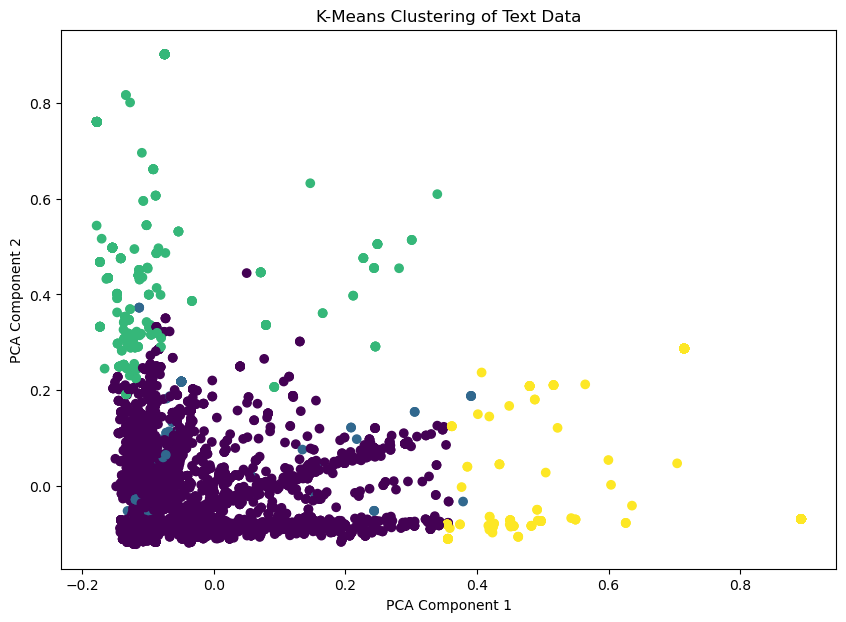

In [67]:
# 결과 시각화 (PCA로 차원 축소)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=df['cluster'], cmap='viridis')
plt.title('K-Means Clustering of Text Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [68]:
# 클러스터링 결과 출력
# print(df[[f'{column_name}', 'cluster']])

In [69]:
# 분석 진행할 문자열 컬럼을 리스트에서 문자열로 변환
df_temp = df.copy()
df_temp[f'{column_name}'] = df_temp[f'{column_name}'].apply(lambda x: ' '.join(x))

In [70]:
# 각 클러스터별 단어 빈도 계산
terms = tfidf_vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

In [71]:
# 각 클러스터별 상위 단어 추출 및 빈도수 계산
# num_terms = (상위 단어 수)
def get_top_terms_per_cluster(num_terms=10):
    cluster_term_dict = {}
    
    for cluster_num in range(4):
        print(f"\nCluster {cluster_num} Top Terms:")
        cluster_docs = df_temp[df_temp['cluster'] == cluster_num][f'{column_name}']  # 클러스터에 속한 문서들
        term_counts = {}
        
        for doc in cluster_docs:
            for term in doc.split():  # 문자열을 단어로 나누기
                if term in term_counts:
                    term_counts[term] += 1
                else:
                    term_counts[term] = 1
        
        top_terms = sorted(term_counts.items(), key=lambda item: item[1], reverse=True)[:num_terms]
        cluster_term_dict[cluster_num] = top_terms
        print(top_terms)
    
    return cluster_term_dict

top_terms_per_cluster = get_top_terms_per_cluster(num_terms=20)


Cluster 0 Top Terms:
[('lg', 2659), ('product', 2600), ('good', 1873), ('service', 1397), ('buy', 1384), ('tv', 1372), ('installation', 1231), ('ac', 1161), ('cool', 1038), ('quality', 1023), ('bad', 1011), ('time', 984), ('get', 971), ('machine', 940), ('work', 888), ('day', 822), ('amazon', 755), ('wash', 739), ('even', 730), ('use', 725)]

Cluster 1 Top Terms:
[('nice', 277), ('product', 116), ('good', 18), ('tv', 9), ('installation', 7), ('price', 6), ('lg', 6), ('picture', 6), ('quality', 6), ('go', 5), ('money', 5), ('service', 5), ('time', 5), ('value', 4), ('refrigerator', 4), ('pic', 4), ('high', 4), ('delivery', 4), ('performance', 4), ('thanks', 4)]

Cluster 2 Top Terms:
[('bad', 538), ('product', 236), ('experience', 80), ('quality', 75), ('service', 55), ('cool', 53), ('good', 52), ('lg', 50), ('installation', 41), ('buy', 40), ('ac', 35), ('picture', 23), ('tv', 23), ('ever', 22), ('customer', 18), ('work', 17), ('flipkart', 17), ('low', 16), ('poor', 16), ('also', 16)]


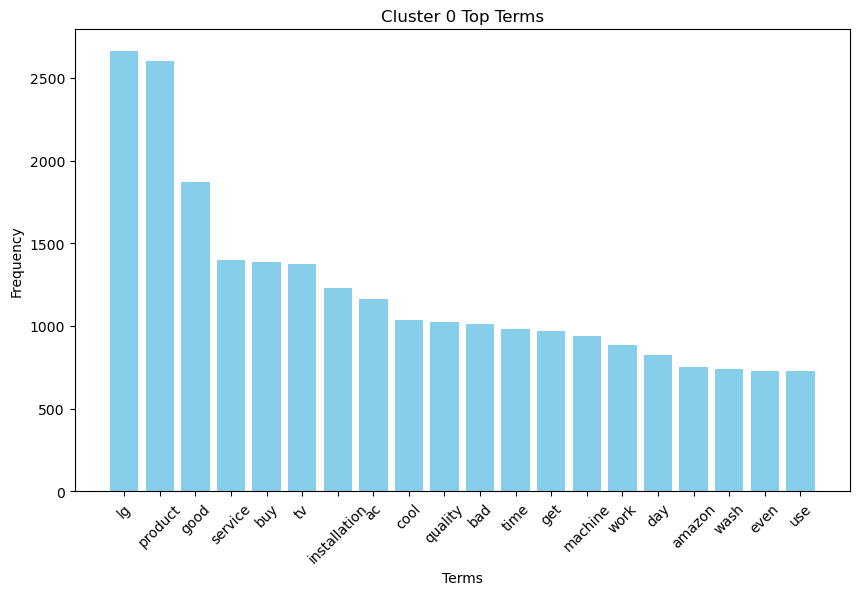

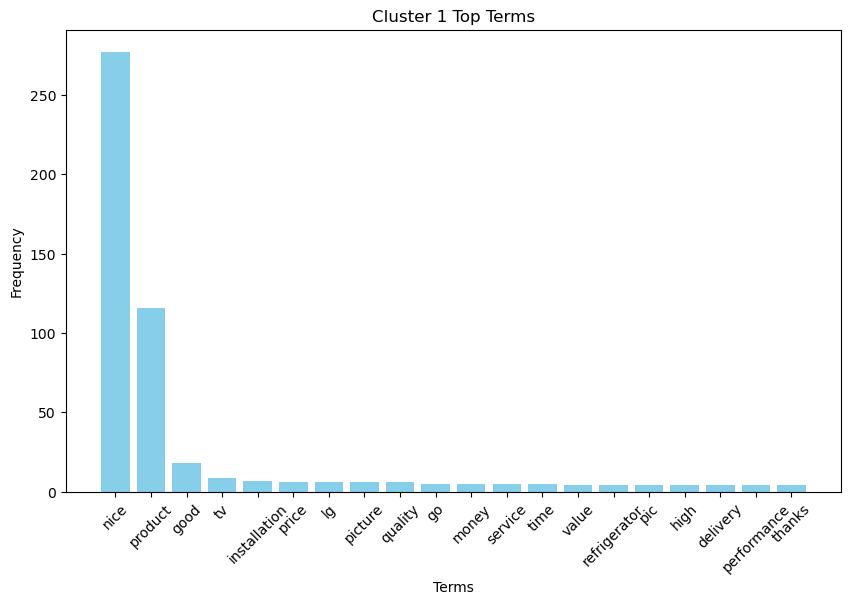

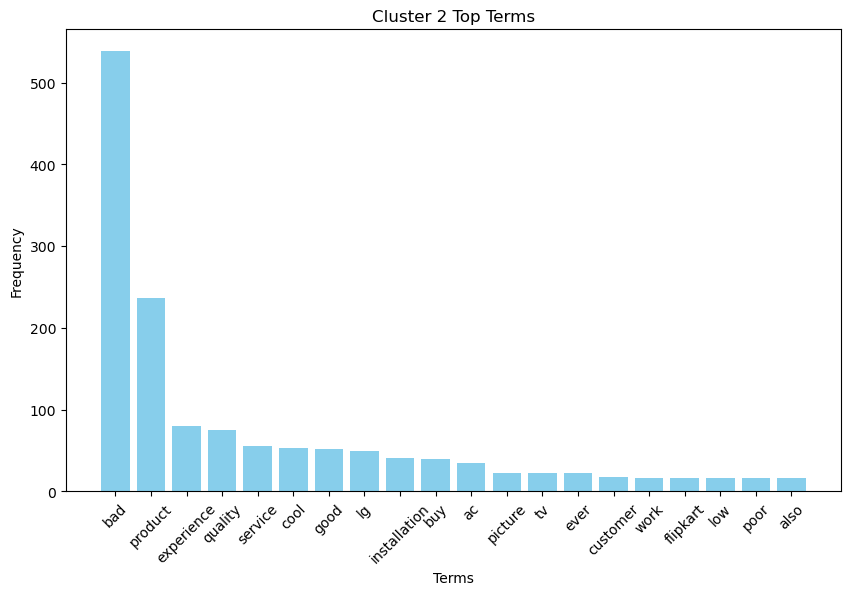

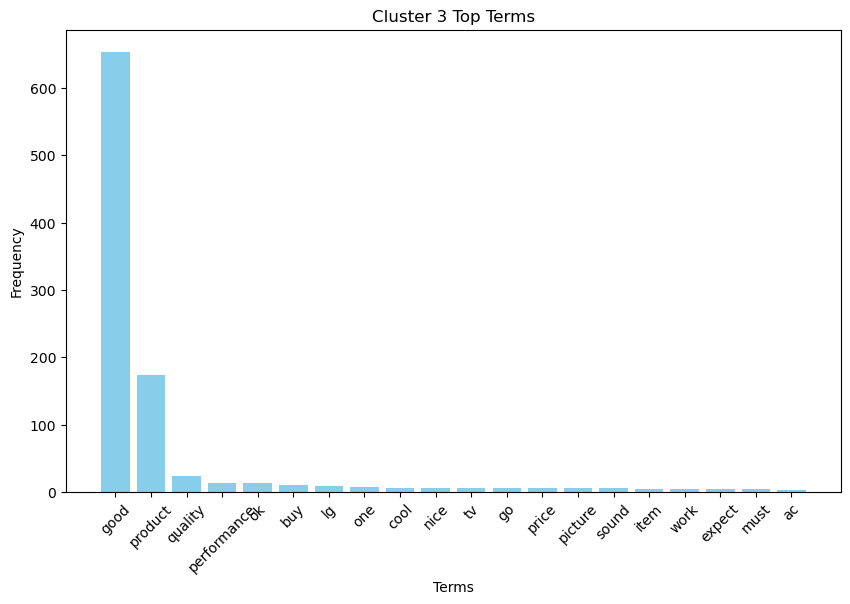

In [72]:
# 클러스터별 상위 단어 바 그래프
def plot_top_terms_per_cluster(cluster_term_dict):
    for cluster_num, terms in cluster_term_dict.items():
        terms, frequencies = zip(*terms)  # 단어와 빈도를 분리
        
        plt.figure(figsize=(10, 6))
        plt.bar(terms, frequencies, color='skyblue')
        plt.title(f'Cluster {cluster_num} Top Terms')
        plt.xlabel('Terms')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.show()

plot_top_terms_per_cluster(top_terms_per_cluster)

### 5. LDA 분석
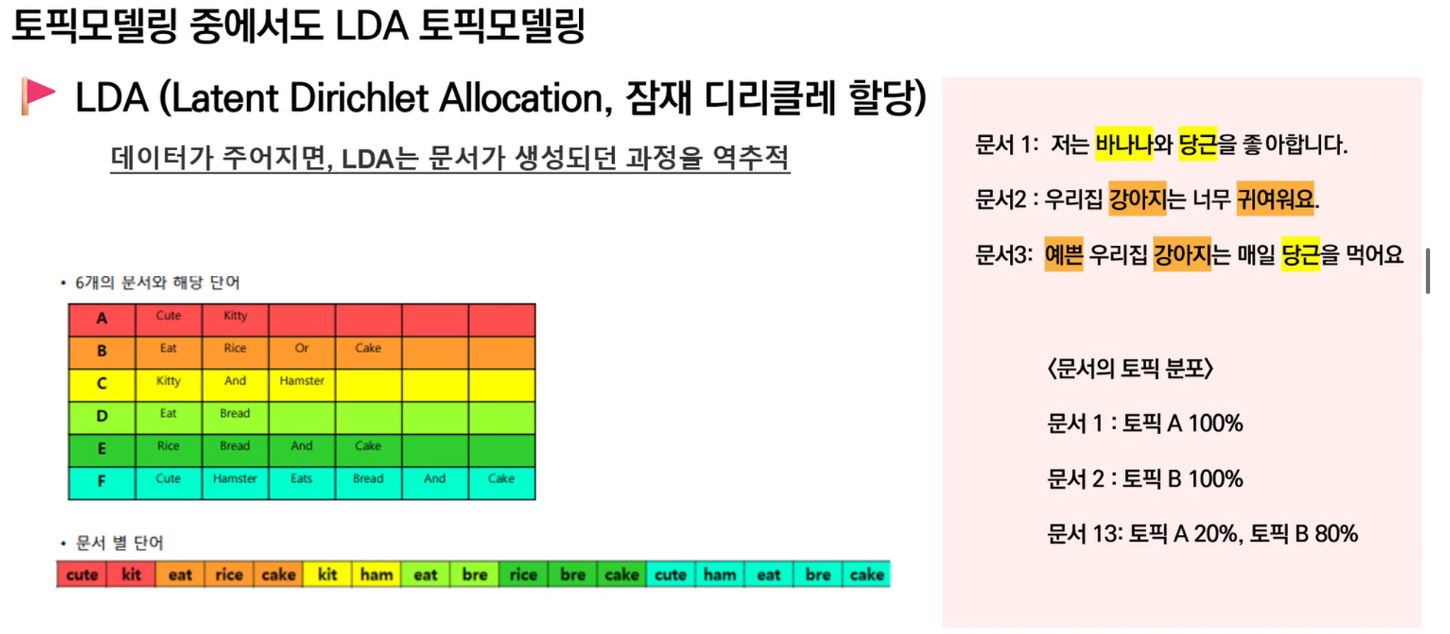

#### ✨✨분석 진행할 클러스터 선정
- 클러스터 선정 파트에서 분석한 데이터를 기반으로! 여기서 최종적으로 LDA 분석 진행할 클러스터 선정!!
- 해당 코드는 예시로 0번째 클러스터를 선택
- 만약 클러스터 분류 없이 바로 LDA 분석을 진행하고 싶으시다면 '4. 클러스터 선정'을 건너띄고 df_cluster = df.copy()로 아래 코드 수정 후에 진행하시면 됩니다. 

In [75]:
df_cluster = df[df['cluster']==0].copy() # 참고 : https://emilkwak.github.io/pandas-dataframe-settingwithcopywarning
df_cluster.head()

,Unnamed: 0,text,star,original,cluster
0,0,"[waste, money, ac, work, till, one, month, ins...",1,Waste of money . AC not working till one month...,0
1,1,"[purchase, lg, april, the, horrible, experienc...",1,I purchased this LG A. C. on 17 April 23..The ...,0
2,2,"[want, buy, white, showpiece, bedroom, go, ahe...",1,If you want to buy a white showpiece for your ...,0
3,3,"[totally, waste, money, company, refund, money...",1,Totally waste of money. company is not refund ...,0
4,4,"[model, way, swing, actual, ton, cooling, capa...",1,"This model don't have 4 way swing, it's actual...",0


#### 1) 전체 단어의 사전 만들고 각 문서에 매칭
- 코드 그대로 따라했는데 각 문서에 매칭한다는 내용은 잘 모르겠어요

In [77]:
all_documents=list(df_cluster[f'{column_name}']) # 'text' 컬럼 지정
dictionary=Dictionary(all_documents)
# dictionary.token2id # 확인용

In [78]:
corpus=[]
for doc in all_documents:
    corpus.append(dictionary.doc2bow(doc))
corpus[0] #ID 값, 빈도

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 1),
 (14, 2),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 2),
 (19, 1)]

#### 2) LDA 모델 만들기

##### 2-1) LDA 토픽개수 선정
-  perplexcity & coherence
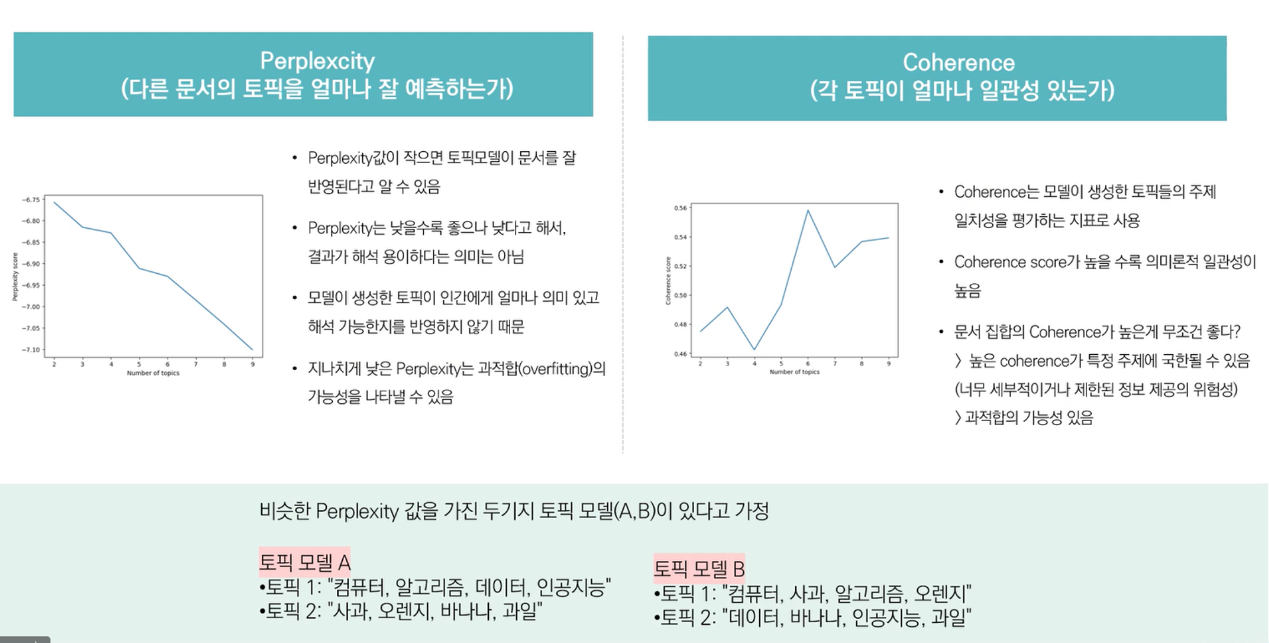
- 토픽개수 선정 기준 (잘 기억이 안나는데 여기서 말하는 클러스터수가 토픽개수라는 의미이지 않을까하는...)
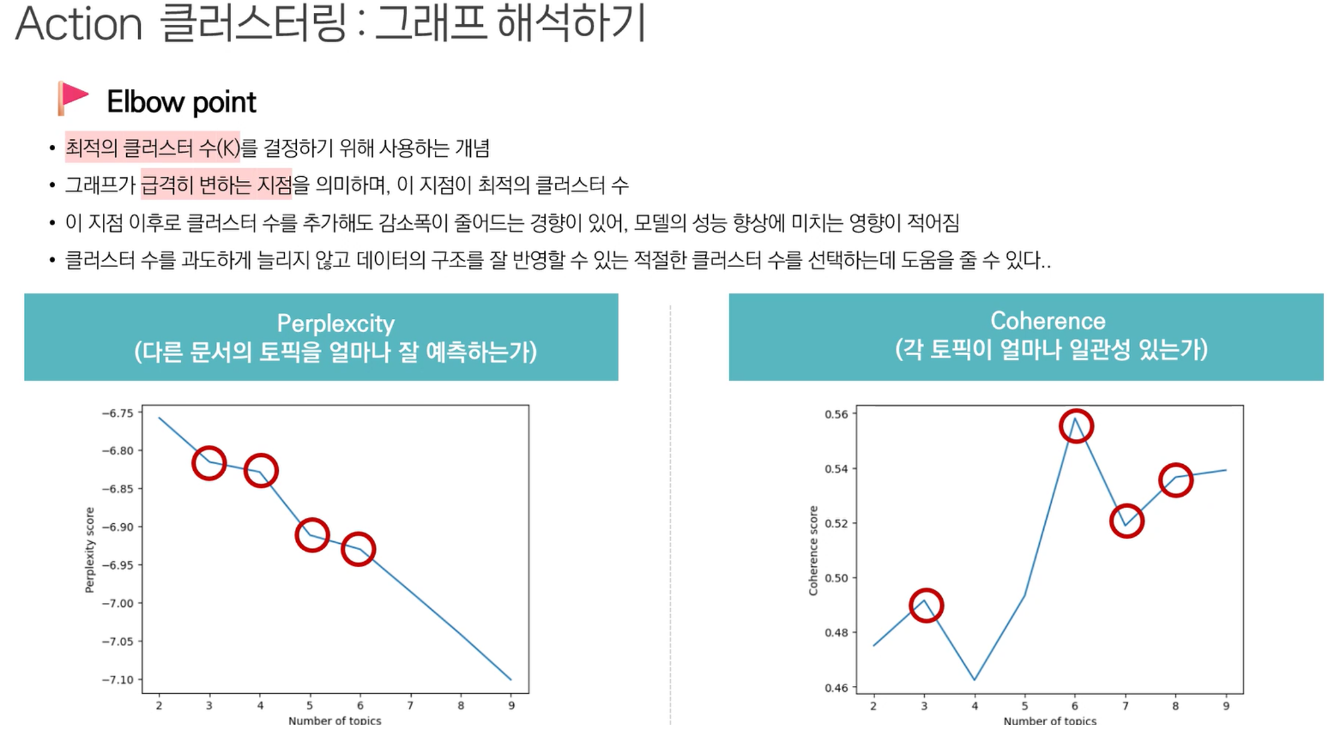

###### 2-1-1) Perplexity 그래프 만들기

In [82]:
# random_seed = 1 # (변경 옵션) LDA는 확률형 모델이라 난수 통제 필요. 임시적으로 1 지정
# perplex_values=[]

# # (변경 옵션) range(2,20)의 범위로 LDA 모델 생성 후 perplexity 값들 저장
# for i in range(2,20):
#     ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, random_state=random_seed)
#     perp_v=ldamodel.log_perplexity(corpus) # 결과값
#     perplex_values.append(perp_v)

# # 시각화
# x= range(2,20)
# plt.plot(x, perplex_values)
# plt.xlabel('Number of topics')
# plt.ylabel('Perplexity score')

###### 2-1-2) Coherence 그래프 만들기 -> 시간이 상당히 소요되니 볼 필요 없으면 주석 처리 추천

In [84]:
# random_seed = 1 # (변경 옵션) LDA는 확률형 모델이라 난수 통제 필요. 임시적으로 1 지정
# cohearence_values=[]

# # (변경 옵션) range(2,10)의 범위로 LDA 모델 생성 후 coherence 값들 저장
# for i in range(2,10):
#     ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
#     cohearence_model=CoherenceModel(model=ldamodel, texts=all_documents, dictionary=dictionary, topn=i)
#     cohearence_score=cohearence_model.get_coherence()
#     cohearence_values.append(cohearence_score)

# # 시각화
# x=range(2,10)
# plt.plot(x, cohearence_values)
# plt.xlabel('Number of topics')
# plt.ylabel('Cohearence score')

##### 2-2) 선정한 토픽 개수로 Action넘버 매칭
- 해당 코드는 임의값으로 5를 선정

In [86]:
topic_n = 6 # (필수 변경 옵션) 선정한 토픽 개수
random_seed = 1
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_n, id2word = dictionary, random_state = random_seed, passes=10, iterations=20)

In [87]:
action_align=[]

for doc in tqdm(ldamodel.get_document_topics(corpus)):
    label=[]
    value=[]

    for score in doc:
        label.append(score[0])
        value.append(score[1]) # label 값, value값 분리

    max_index=np.argmax(value)
    action_n=label[max_index]
    action_align.append(action_n)

100%|██████████| 6835/6835 [00:00<00:00, 10442.83it/s]


In [88]:
ldamodel.get_document_topics(corpus)[0]

[(1, 0.4509253), (3, 0.39986366), (4, 0.12829407)]

In [89]:
df_cluster['action_cluster'] = action_align

#### 3) LDA 시각화 (LDAvis)
- 원의 크기 : 토픽의 단어들이 얼마나 속해 있고 어떻게 분포 되어있는지
- 원의 거리 : 토픽 간의 유사성 (두 개의 원이 겹친다면 , 두 개의 토픽은 유사한 토픽이라는 의미)
- λ  =1 일수록,
토픽 별로 가장 자주 등장하는 단어들을 우선적으로 키워드로 선택한다는 의미
- λ = 0 일수록,
토픽 간에 차이가 많이 나는 단어를 선택한다는 의미 (해당 토픽에서 많이 등장한 단어)

In [91]:
prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(prepared_data, './4. LDA_result/ldavis_actor_0.html') # html로 저장
pyLDAvis.display(prepared_data)

##### 3-1 LDA 분석을 위한 후작업
- LDAvis(시각화 결과)와 LDA모델의 토픽 넘버가 다르기 때문에 이를 매칭하는 작업
- LDAvis 결과와 LDA모델의 결과를 보고 매칭
- 감성 분석을 위한 단계?인 듯하지만 일단 코드에 포함

In [93]:
# LDA 모델 토픽 넘버 확인
topics = ldamodel.show_topics(num_topics=-1, formatted=True)
topics

[(0,
  '0.038*"cool" + 0.033*"ac" + 0.017*"noise" + 0.016*"load" + 0.015*"lg" + 0.015*"room" + 0.013*"take" + 0.013*"time" + 0.013*"buy" + 0.011*"much"'),
 (1,
  '0.029*"lg" + 0.024*"service" + 0.021*"product" + 0.018*"day" + 0.016*"issue" + 0.015*"amazon" + 0.014*"buy" + 0.012*"get" + 0.011*"installation" + 0.010*"say"'),
 (2,
  '0.021*"small" + 0.019*"refrigerator" + 0.017*"fridge" + 0.017*"size" + 0.013*"kg" + 0.012*"drum" + 0.008*"freezer" + 0.007*"purchase" + 0.007*"amazon" + 0.007*"space"'),
 (3,
  '0.036*"lg" + 0.030*"installation" + 0.027*"product" + 0.025*"service" + 0.019*"customer" + 0.018*"amazon" + 0.014*"good" + 0.013*"call" + 0.013*"time" + 0.013*"come"'),
 (4,
  '0.074*"machine" + 0.052*"wash" + 0.047*"product" + 0.022*"lg" + 0.021*"buy" + 0.014*"clothes" + 0.014*"time" + 0.014*"work" + 0.014*"use" + 0.013*"bad"'),
 (5,
  '0.051*"tv" + 0.045*"good" + 0.039*"quality" + 0.025*"sound" + 0.017*"picture" + 0.015*"lg" + 0.013*"panel" + 0.013*"model" + 0.012*"display" + 0.012*

In [94]:
# LDAvis와 LDA모델의 결과를 비교하며 매칭
# 참고로 아래는 단순히 예시이기 때문에 엉망인 매칭입니다.
new_action_topic = []

for k in df_cluster.action_cluster :
    if k == 0 : # 처음에 설정한 액션 토픽 넘버
        n = 5 # vis에서 나온 토픽 넘버
    elif k == 1 :
        n = 1
    elif k == 2 :
        n = 6
    elif k == 3:
        n = 2
    elif k == 4:
        n = 4
    elif k == 5:
        n = 3
    new_action_topic.append(n)

df_cluster['action_cluster'] = new_action_topic # 이건 감성 분석을 위한 단계 아닌가..?

In [95]:
df_cluster['action_cluster'].value_counts()

action_cluster
3    1531
4    1259
2    1217
5    1180
1    1139
6     509
Name: count, dtype: int64

In [96]:
# LDA 시각화 결과와 액션 클러스터의 인덱스를 매칭한 결과를 csv 형태로 저장
df_cluster.to_csv("./4. LDA_result/df_cluseter_0_action_cluster_save.csv")
df_cluster.head()

,Unnamed: 0,text,star,original,cluster,action_cluster
0,0,"[waste, money, ac, work, till, one, month, ins...",1,Waste of money . AC not working till one month...,0,1
1,1,"[purchase, lg, april, the, horrible, experienc...",1,I purchased this LG A. C. on 17 April 23..The ...,0,5
2,2,"[want, buy, white, showpiece, bedroom, go, ahe...",1,If you want to buy a white showpiece for your ...,0,1
3,3,"[totally, waste, money, company, refund, money...",1,Totally waste of money. company is not refund ...,0,4
4,4,"[model, way, swing, actual, ton, cooling, capa...",1,"This model don't have 4 way swing, it's actual...",0,5


#### 추가) 특정 키워드를 포함하는 텍스트 원문 찾기

In [98]:
# DataFrame에서 특정 키워드를 포함하는 원문들을 찾는 함수.
def df_find_keyword_in_texts(df, column_name, keyword, action_cluster):
    if(action_cluster=="all"):
        filtered_df = df[df[column_name].str.contains(keyword, na=False, case=False)]
        return filtered_df[[column_name,"action_cluster"]]
    else:
        action_filtered_df = df[df['action_cluster'] == int(action_cluster)]
        filtered_df = action_filtered_df[action_filtered_df[column_name].str.contains(keyword, na=False, case=False)]
        return filtered_df[[column_name,"action_cluster"]]

# 문자열 내 특정 키워드를 하이라이트하는 함수
def highlight_keyword(s, keyword):
    if isinstance(s, str):  # 문자열인지 확인
        # re.sub을 사용하여 대소문자 구분 없이 키워드를 하이라이트
        highlighted = re.sub(f'({keyword})', r'<span style="background-color: yellow">\1</span>', s, flags=re.IGNORECASE)
        return highlighted
    return s  # 문자열이 아니면 원본 반환

# DataFrame 내 모든 문자열에서 특정 키워드를 하이라이트하는 함수
def df_highlight_keyword(df, keyword):
    return df.style.format(lambda x: highlight_keyword(x, keyword))

In [99]:
# 찾고자 하는 키워드 선택
# 찾고자 하는 액션 클러스터 넘버 선택(단, 문자열 형태로. ex) "all", "1", "2", "3", "4")
keyword = "small" 
action_cluster_number = "6"
pd.set_option('display.max_colwidth', None) # 컬럼 너비 제한 해제
df_find_keywords = df_find_keyword_in_texts(df_cluster, "original", keyword, action_cluster_number)
df_highlight_keyword(df_find_keywords, keyword)

,original,action_cluster
458,Very good and budget ac but size is small,6
1252,Size is very small,6
1253,Very small size,6
1254,I don't like that. small refrigerator loss of money,6
1260,Not satisfied refrigerator need to return Very small accessories,6
1265,Good. But with indoor space I am not satisfy. The indoor space is Small.. Main point LG refrigerator boday toooooooooooo low quality.,6
1269,Inside arrangement and vegetable tray size is comparatively small.,6
1291,Overall good product.... Product hight is slightly small....,6
1313,"Everything is very well poised in terms of utility and design of the refrigerator fantastically executed keeping in mind the need of a very small family. I only have one complain regarding the crispier basket, should have been a little bigger.",6
1348,Very very very poor quality Hlw gyes Don't buy this product because Doesn't cooling this refrigerator and very very very small,6
